In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
from tqdm import tqdm

# Model

In [2]:
B = pd.read_parquet('../data/B_HKML.parquet')
all_epochs = B.date.unique()
batch_size = 25
epochs = all_epochs[:batch_size]
X_df = pd.read_parquet('../data/B_HKML.parquet')
X_train = X_df[X_df['date'].isin(epochs)].drop('date', axis=1).to_numpy()

In [3]:
i = B.shape[1]-1
j = 0
for epoch in epochs:
    B_np = B[B['date'] == epoch].drop('date', axis=1).to_numpy().T
    j += B_np.shape[1]

Batch_B = np.zeros((i, j))

j = 0
for epoch in epochs:
    B_np = B[B['date'] == epoch].drop('date', axis=1).to_numpy().T
    dj = B_np.shape[1]
    Batch_B[:, j:j+dj] = B_np
    
    j += dj
B_train = Batch_B

# Gaussianize Target

In [4]:
import sys

sys.path.insert(1, "../../../Feature engg/feature-engineering/src")
from class_ import Data

y_df = pd.read_parquet('../data/Y_HKML.parquet')

In [5]:
y_date = pd.concat([X_df['date'], y_df], axis=1)
data = Data(f_matrix=y_date, b_matrix=B)
data.gaussianize()
data.standardize()
y_date = data.f_matrix
y_df = y_date.iloc[:, 1]
y_train = y_df.iloc[:len(X_train)].to_numpy().ravel()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# compute coefficients

In [6]:
metric = "linear"

In [7]:
# Values of C and D to be fine tuned to have good mse out of sample and good orthogonality out of sample?
C = 3.0
D = 100.0

K = pairwise_kernels(X_train, metric = metric )
BBK = B_train.T @ B_train @ K
M = K + C*np.identity(K.shape[0]) + D * BBK
dual_coef = np.linalg.solve(M, y_train)

# Estimate

In [8]:
future_moons = 50
y_hat_df = pd.DataFrame()
y_hat_df['date'] = X_df[X_df['date'].isin(all_epochs[batch_size:batch_size+future_moons])].date
y_hat_df['y_hat'] =  np.nan
y_hat_df['y_test'] =  np.nan

In [9]:
for moon in tqdm(range(future_moons)):
    epochs = all_epochs[0:batch_size+moon+1]

    j = 0
    for epoch in epochs:
        B_np = B[B['date'] == epoch].drop('date', axis=1).to_numpy().T
        j += B_np.shape[1]

    Batch_B = np.zeros((i, j))

    j = 0
    for epoch in epochs:
        B_np = B[B['date'] == epoch].drop('date', axis=1).to_numpy().T
        dj = B_np.shape[1]
        Batch_B[:, j:j+dj] = B_np

        j += dj
    B_test = Batch_B

    X_test = X_df[X_df['date'].isin(epochs)].drop('date', axis=1).to_numpy()

    y_test = y_df.iloc[:len(X_test)].to_numpy().ravel()
    
    K_hat = pairwise_kernels(X_test, X_train, metric= metric)
    
    y_hat = K_hat @ dual_coef
    
    exp_vec = (B_test @ y_hat)
    exp = np.dot(exp_vec, exp_vec)
    
    # print('Factor Exposure')
    # print(exp)
    # leastsquare = np.dot(y_test - y_hat, y_test - y_hat)
    # print('Least Square Error')
    # print(leastsquare)
    # ridge = K_hat @ dual_coef
    # print('Regularization Loss')
    # print(np.dot(ridge, ridge))
    
    y_hat_df.loc[y_hat_df['date'] == epochs[-1], 'y_hat'] = y_hat[-dj:]
    y_hat_df.loc[y_hat_df['date'] == epochs[-1], 'y_test'] = y_test[-dj:]


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


In [ ]:
def spear(x):
    spear = x.corr(numeric_only=True, method='spearman')
    spear = spear.iloc[0, 1]
    return spear

In [ ]:
spearman_history = y_hat_df.groupby('date').apply(lambda x: spear(x))

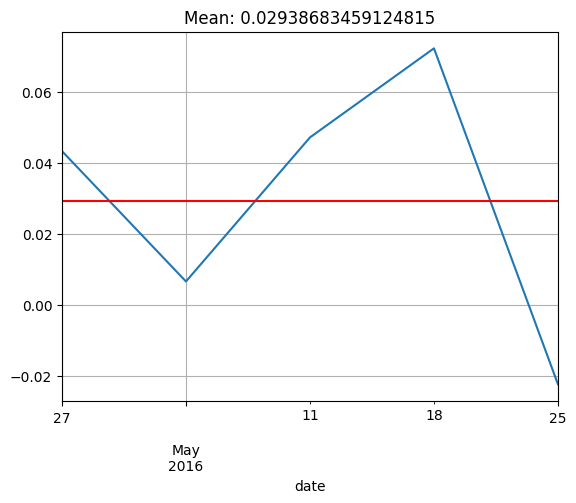

In [ ]:
spearman_history.plot(grid='on')
plt.axhline(y=spearman_history.mean(), color='r', linestyle='-')
plt.title(f"Spearman $(\mu$={round(spearman_history.mean(), 6)}, $\sigma$ = {round(spearman_history.std(), 6)})")
plt.show()

In [ ]:
def pear(x):
    pear = x.corr(numeric_only=True)
    pear = pear.iloc[0, 1]
    return pear

In [ ]:
pearson_history = y_hat_df.groupby('date').apply(lambda x: pear(x))

In [ ]:
pearson_history.plot(grid='on')
plt.axhline(y=pearson_history.mean(), color='r', linestyle='-')
plt.title(f"Pearson $(\mu$={round(pearson_history.mean(), 6)}, $\sigma$ = {round(pearson_history.std(), 6)})")
plt.show()

In [ ]:
mse_history = y_hat_df.groupby('date').apply(lambda x: mean_squared_error(x.iloc[:, 1], x.iloc[:, 2]))
mse_history.plot(grid='on')
plt.axhline(y=mse_history.mean(), color='r', linestyle='-')
plt.title(f"MSE $(\mu$={round(mse_history.mean(), 6)}, $\sigma$ = {round(mse_history.std(), 6)})")
plt.show()

# Orthogonalize predictions

In [ ]:
y_hat_date = y_hat_df[['date', 'y_hat']]
b_matrix = B[B['date'].isin(all_epochs[batch_size:batch_size+future_moons])]
data = Data(f_matrix=y_hat_date, b_matrix=b_matrix)
data.orthogonalize()
y_hat_date = data.f_matrix
y_hat_df['y_hat'] = y_hat_date['y_hat']
orth_spearman_history = y_hat_df.groupby('date').apply(lambda x: spear(x))

In [ ]:
orth_spearman_history.plot(grid='on')
plt.axhline(y=orth_spearman_history.mean(), color='r', linestyle='-')
plt.title(f"Spearman $(\mu$={round(orth_spearman_history.mean(), 6)}, $\sigma$ = {round(orth_spearman_history.std(), 6)})")
plt.show()

In [ ]:
orth_pearson_history = y_hat_df.groupby('date').apply(lambda x: pear(x))

In [ ]:
orth_pearson_history.plot(grid='on')
plt.axhline(y=orth_pearson_history.mean(), color='r', linestyle='-')
plt.title(f"Pearson $(\mu$={round(orth_pearson_history.mean(), 6)}, $\sigma$ = {round(orth_pearson_history.std(), 6)})")
plt.show()

In [ ]:
orth_mse_history = y_hat_df.groupby('date').apply(lambda x: mean_squared_error(x.iloc[:, 1], x.iloc[:, 2]))
orth_mse_history.plot(grid='on')
plt.axhline(y=orth_mse_history.mean(), color='r', linestyle='-')
plt.title(f"MSE $(\mu$={round(orth_mse_history.mean(), 6)}, $\sigma$ = {round(orth_mse_history.std(), 6)})")
plt.show()